## Business Question 3 - Factors influencing price

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

In [35]:
df = pd.read_csv('./Seattle/listings.csv')
selected_columns = ['id', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
                    'host_total_listings_count', 'host_has_profile_pic', 'host_identity_verified',
                    'neighbourhood_group_cleansed', 'latitude', 'longitude', 'is_location_exact',
                    'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 
                    'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
                    'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
                    'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
                    'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 
                    'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', 
                    'require_guest_phone_verification', 'reviews_per_month']
listings_df = df[selected_columns]
listings_df.shape
listings_df.head()

,id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,latitude,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
0,241032,within a few hours,96%,100%,f,3.0,t,t,Queen Anne,47.636289,...,10.0,10.0,10.0,9.0,10.0,f,moderate,f,f,4.07
1,953595,within an hour,98%,100%,t,6.0,t,t,Queen Anne,47.639123,...,10.0,10.0,10.0,10.0,10.0,f,strict,t,t,1.48
2,3308979,within a few hours,67%,100%,f,2.0,t,t,Queen Anne,47.629724,...,10.0,10.0,10.0,10.0,10.0,f,strict,f,f,1.15
3,7421966,NaN,NaN,NaN,f,1.0,t,t,Queen Anne,47.638473,...,NaN,NaN,NaN,NaN,NaN,f,flexible,f,f,NaN
4,278830,within an hour,100%,NaN,f,2.0,t,t,Queen Anne,47.632918,...,9.0,10.0,10.0,9.0,9.0,f,strict,f,f,0.89


To understand why the above 43 columns are selected, please refer to the notebook Business and Data Understanding.pynb.

### Data Preparation

square_feet                    0.974594
monthly_price                  0.602672
security_deposit               0.511262
weekly_price                   0.473808
cleaning_fee                   0.269775
host_acceptance_rate           0.202462
review_scores_checkin          0.172342
review_scores_accuracy         0.172342
review_scores_value            0.171818
review_scores_location         0.171556
review_scores_cleanliness      0.171032
review_scores_communication    0.170508
review_scores_rating           0.169460
reviews_per_month              0.164222
host_response_rate             0.136983
host_response_time             0.136983
bathrooms                      0.004191
bedrooms                       0.001572
host_identity_verified         0.000524
host_has_profile_pic           0.000524
host_total_listings_count      0.000524
host_is_superhost              0.000524
property_type                  0.000262
beds                           0.000262
dtype: float64


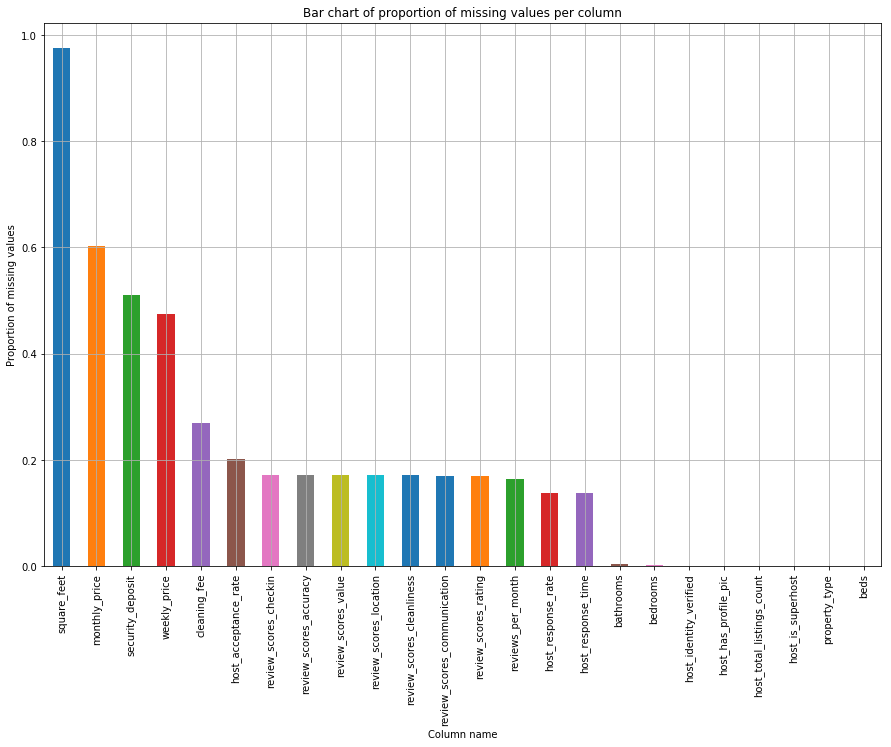

In [37]:
# check missing values in columns
nan_percentage_per_column = listings_df.isnull().mean()
columns_with_nan = nan_percentage_per_column[nan_percentage_per_column > 0]
columns_with_nan.sort_values(inplace=True, ascending=False)
print(columns_with_nan)

columns_with_nan.plot.bar(figsize=(15, 10))
plt.xlabel('Column name')
plt.ylabel('Proportion of missing values')
plt.grid(True)
plt.title('Bar chart of proportion of missing values per column')
plt.show()

In [4]:
outlier_columns = nan_percentage_per_column[nan_percentage_per_column > 0.25]
print(outlier_columns)

square_feet         0.974594
weekly_price        0.473808
monthly_price       0.602672
security_deposit    0.511262
cleaning_fee        0.269775
dtype: float64


In [5]:
listings_df.drop(outlier_columns.index, axis=1, inplace=True)

C:\Users\Rehan.Ahmar\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [6]:
listings_df.drop(['id'], axis=1, inplace=True)

We can see the column square_feet has 97% missing values. We can drop this column.

The columns monthly_price, security_deposit, weekly_price, cleaning_fee also have more than 25% missing values. Moreover, neither we are interested in predicting these values, nor these columns seem to provide much useful information. A listing with high daily price will have higher values in these fields also. So, we drop these columns.

Also, id of listings are of no use in predicting the price. So we drop the 'id' also.

In [7]:
numeric_columns = []
for column in listings_df.columns:
    if np.issubdtype(listings_df[column].dtype, np.number):
        numeric_columns.append(column)
    else:
        print(column, '\t', listings_df[column].nunique(), '\t', listings_df[column].dtype, '\t', listings_df[column].unique())


host_response_time 	 4 	 object 	 ['within a few hours' 'within an hour' nan 'within a day'
 'a few days or more']
host_response_rate 	 45 	 object 	 ['96%' '98%' '67%' nan '100%' '71%' '97%' '60%' '50%' '31%' '90%' '70%'
 '88%' '80%' '63%' '33%' '99%' '75%' '83%' '94%' '58%' '43%' '93%' '92%'
 '40%' '57%' '89%' '95%' '78%' '81%' '91%' '38%' '86%' '30%' '56%' '76%'
 '64%' '82%' '17%' '87%' '25%' '69%' '53%' '65%' '68%' '55%']
host_acceptance_rate 	 2 	 object 	 ['100%' nan '0%']
host_is_superhost 	 2 	 object 	 ['f' 't' nan]
host_has_profile_pic 	 2 	 object 	 ['t' 'f' nan]
host_identity_verified 	 2 	 object 	 ['t' 'f' nan]
neighbourhood_group_cleansed 	 17 	 object 	 ['Queen Anne' 'Ballard' 'Other neighborhoods' 'Cascade' 'Central Area'
 'University District' 'Downtown' 'Magnolia' 'West Seattle' 'Interbay'
 'Beacon Hill' 'Rainier Valley' 'Delridge' 'Seward Park' 'Northgate'
 'Capitol Hill' 'Lake City']
is_location_exact 	 2 	 object 	 ['t' 'f']
property_type 	 16 	 object 	 ['Apartme

In [8]:
print(numeric_columns)

['host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']


In [9]:
# Convert currency columns to numeric
currency_columns = ['price', 'extra_people']
for col in currency_columns:
    listings_df[col] =  pd.to_numeric(listings_df[col].str.replace('[\$,]', '', regex=True))
    #listings_df[col] = listings_df[col].str.replace('[\$,]', '', regex=True).astype(float)

# Convert percentage columns to numeric
percentage_columns = ['host_response_rate', 'host_acceptance_rate']
for col in percentage_columns:
    listings_df[col] = pd.to_numeric(listings_df[col].str.replace('%',''))

C:\Users\Rehan.Ahmar\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Rehan.Ahmar\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [10]:
numeric_binary = [x for x in listings_df.columns if (listings_df[x].nunique()==2 and np.issubdtype(listings_df[x].dtype, np.number))]
non_numeric_binary = [x for x in listings_df.columns if (listings_df[x].nunique()==2 and not np.issubdtype(listings_df[x].dtype, np.number))]
multilevel = [x for x in  listings_df.columns if (listings_df[x].nunique() > 2 and not np.issubdtype(listings_df[x].dtype, np.number))]
print(numeric_binary)
print(non_numeric_binary)
print(multilevel)

['host_acceptance_rate']
['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'is_location_exact', 'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification']
['host_response_time', 'neighbourhood_group_cleansed', 'property_type', 'room_type', 'bed_type', 'amenities', 'cancellation_policy']


In [11]:
# Convert non-numeric binary categoricals to numeric binary categoricals
for col in non_numeric_binary:
    listings_df[col] = listings_df[col].apply(lambda x: 1 if x=='t' else 0)

C:\Users\Rehan.Ahmar\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
# Process amenities column
print(listings_df['amenities'][0])
listings_df['amenities'] = listings_df['amenities'].str.replace('["{}]', '', regex=True)
print(listings_df['amenities'][0])
parsed_amenities = listings_df['amenities'].str.get_dummies(sep = ",")
parsed_amenities.head()

{TV,"Cable TV",Internet,"Wireless Internet","Air Conditioning",Kitchen,Heating,"Family/Kid Friendly",Washer,Dryer}
TV,Cable TV,Internet,Wireless Internet,Air Conditioning,Kitchen,Heating,Family/Kid Friendly,Washer,Dryer


C:\Users\Rehan.Ahmar\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer/Wireless Intercom,Cable TV,Carbon Monoxide Detector,Cat(s),Dog(s),Doorman,Dryer,...,Safety Card,Shampoo,Smoke Detector,Smoking Allowed,Suitable for Events,TV,Washer,Washer / Dryer,Wheelchair Accessible,Wireless Internet
0,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,1,0,0,1
1,0,0,0,1,0,1,0,0,0,1,...,1,0,1,0,0,1,1,0,0,1
2,0,1,0,0,1,1,1,1,0,1,...,0,1,1,0,0,1,1,0,0,1
3,0,0,0,0,0,1,0,0,0,1,...,1,1,1,0,0,0,1,0,0,1
4,0,0,0,0,1,1,0,0,0,0,...,0,1,1,0,0,1,0,0,0,1


In [13]:
parsed_amenities.sum()

24-Hour Check-in               616
Air Conditioning               677
Breakfast                      291
Buzzer/Wireless Intercom       538
Cable TV                      1446
Carbon Monoxide Detector      2485
Cat(s)                         382
Dog(s)                         509
Doorman                         85
Dryer                         2997
Elevator in Building           785
Essentials                    3237
Family/Kid Friendly           1963
Fire Extinguisher             2196
First Aid Kit                 1680
Free Parking on Premises      2167
Gym                            442
Hair Dryer                     774
Hangers                        846
Heating                       3627
Hot Tub                        303
Indoor Fireplace               886
Internet                      2811
Iron                           742
Kitchen                       3423
Laptop Friendly Workspace      745
Lock on Bedroom Door           100
Other pet(s)                    51
Pets Allowed        

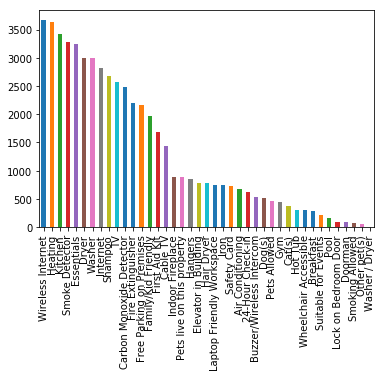

In [14]:
parsed_amenities.sum().sort_values(ascending=False).plot(kind='bar')

In [15]:
parsed_amenities[parsed_amenities['Washer / Dryer'] == 1][['Washer / Dryer', 'Washer']]

,Washer / Dryer,Washer
2376,1,1
3006,1,1


Washer/Dryer is present in only 2 listings. So, we can drop this feature. Washer field is already 1 in these 2 rows.

The fields Cable TV and TV seem to convey the same thing. So we can merge these 2 columns.
Same is the case for the fields Internet and Wireless Internet. We can merge these 2 also.

In [16]:
# Drop amenity Washer / Dryer
parsed_amenities.drop(['Washer / Dryer'], axis=1, inplace=True)
# Merge TV and Cable TV, and drop Cable TV
parsed_amenities['TV'] = (parsed_amenities['TV'] | parsed_amenities['Cable TV']).astype(int)
parsed_amenities['Wireless Internet'] = (parsed_amenities['Wireless Internet'] | parsed_amenities['Internet']).astype(int)
parsed_amenities.drop(['Cable TV', 'Internet'], axis=1, inplace=True)

In [17]:
print(listings_df.shape)
merged_df = pd.merge(listings_df, parsed_amenities, left_index=True, right_index=True)
print(merged_df.shape)

(3818, 37)
(3818, 75)


In [18]:
# Remove amenities column
merged_df.drop(['amenities'], axis=1, inplace = True)
multilevel.remove('amenities')

In [19]:
# One-hot encode remaining categoricals
final_df = pd.get_dummies(data=merged_df, columns=multilevel)
print(final_df.shape)
final_df.head()

(3818, 116)


,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,accommodates,...,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict
0,96.0,100.0,0,3.0,1,1,47.636289,-122.371025,1,4,...,0,0,0,0,0,0,1,0,1,0
1,98.0,100.0,1,6.0,1,1,47.639123,-122.365666,1,4,...,0,0,0,0,0,0,1,0,0,1
2,67.0,100.0,0,2.0,1,1,47.629724,-122.369483,1,11,...,0,0,0,0,0,0,1,0,0,1
3,NaN,NaN,0,1.0,1,1,47.638473,-122.369279,1,3,...,0,0,0,0,0,0,1,1,0,0
4,100.0,NaN,0,2.0,1,1,47.632918,-122.372471,1,6,...,0,0,0,0,0,0,1,0,0,1


In [20]:
list(final_df.columns)

['host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_total_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'latitude',
 'longitude',
 'is_location_exact',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'price',
 'guests_included',
 'extra_people',
 'minimum_nights',
 'maximum_nights',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'instant_bookable',
 'require_guest_profile_picture',
 'require_guest_phone_verification',
 'reviews_per_month',
 '24-Hour Check-in',
 'Air Conditioning',
 'Breakfast',
 'Buzzer/Wireless Intercom',
 'Carbon Monoxide Detector',
 'Cat(s)',
 'Dog(s)',
 'Doorman',
 'Dryer',
 'Elevator in Building',
 'Essentials',
 'Family/Kid Friendly',
 'Fire Extinguisher',
 'First Aid Kit',
 'Free Parking on Premises',
 'Gym',
 'Hair Dryer',
 'Hangers',
 'Heatin

In [21]:
#Check again which columns have null values
columns_with_nan = final_df.columns[final_df.isnull().any()]
print(columns_with_nan)
for column in columns_with_nan:
    print(column, '\t', final_df[column].nunique(), '\t', final_df[column].dtype, '\t', final_df[column].unique())

Index(['host_response_rate', 'host_acceptance_rate',
       'host_total_listings_count', 'bathrooms', 'bedrooms', 'beds',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month'],
      dtype='object')
host_response_rate 	 45 	 float64 	 [ 96.  98.  67.  nan 100.  71.  97.  60.  50.  31.  90.  70.  88.  80.
  63.  33.  99.  75.  83.  94.  58.  43.  93.  92.  40.  57.  89.  95.
  78.  81.  91.  38.  86.  30.  56.  76.  64.  82.  17.  87.  25.  69.
  53.  65.  68.  55.]
host_acceptance_rate 	 2 	 float64 	 [100.  nan   0.]
host_total_listings_count 	 27 	 float64 	 [  3.   6.   2.   1.   5.   9.   4.  36. 354.   8.  37.   7.  34.  10.
  13.  21.  11. 169.  48. 502.  12.  nan  18.  19.  15.  84. 163.  17.]
bathrooms 	 12 	 float64 	 [1.  4.5 2.  3.5 1.5 2.5 3.  0.5 4.  0.  8.  nan 5. ]
bedrooms 	 8 	 float64 	 [ 1. 

Most of the columns with NaN have numeric values. 
3 columns 'bathrooms', 'bedrooms', 'beds' need special handling, as it would not be wise to impute these values with simple mean/median. For these columns, we impute with the median of the group of listings with same number of bedrooms/bathrooms.

Remaining nulls are imputed with median values of the respective columns.

In [22]:
final_df['bathrooms'].fillna(final_df.groupby("bedrooms")["bathrooms"].transform("median"), inplace=True)
final_df['bedrooms'].fillna(final_df.groupby("bathrooms")["bedrooms"].transform("median"), inplace=True)
final_df['beds'].fillna(final_df.groupby("bedrooms")["beds"].transform("median"), inplace=True)

In [23]:
#final_df['reviews_per_month'].fillna(final_df['reviews_per_month'].mean(), inplace=True)

#impute remaining columns with median
imputer = Imputer(missing_values=np.nan, strategy='median')
imputed_df = pd.DataFrame(imputer.fit_transform(final_df), columns=final_df.columns)

# Check whether any null values are still present
imputed_df.columns[imputed_df.isnull().any()]

C:\Users\Rehan.Ahmar\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Index([], dtype='object')

In [24]:
# scale the data using MinMax Scaler
scaler = MinMaxScaler()
#scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(imputed_df), columns = imputed_df.columns)
scaled_df.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,accommodates,...,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict
0,0.951807,1.0,0.0,0.003992,1.0,1.0,0.574762,0.261555,1.0,0.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.975904,1.0,1.0,0.009980,1.0,1.0,0.587178,0.291896,1.0,0.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.602410,1.0,0.0,0.001996,1.0,1.0,0.546003,0.270286,1.0,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.000000,1.0,0.0,0.000000,1.0,1.0,0.584330,0.271441,1.0,0.133333,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1.000000,1.0,0.0,0.001996,1.0,1.0,0.559996,0.253370,1.0,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [25]:
#fig, ax = plt.subplots(figsize=(20,20)) 
#sns.heatmap(scaled_df.loc[:, :'reviews_per_month'].corr(), annot=True, fmt="0.2f")

I have used MinMaxScaler to scale the data. This was done to preserve the binary property of dummy variables.

### Modelling

In [26]:
price_df = final_df['price']
scaled_df.drop(['price'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(scaled_df, price_df, test_size = 0.2, shuffle=True, random_state = 42)
print(X_train.shape)
print(X_test.shape)

(3054, 115)
(764, 115)


In [27]:
# Evaluate the performance with Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)
mse_train = mean_squared_error(y_train, predictions_train)
mse_test = mean_squared_error(y_test, predictions_test)
print('Mean Squared Error:\n  Train: {:.2f} \t Test: {:.2f}'.format(mse_train, mse_test))
print('Root mean Squared Error:\n  Train: {:.2f} \t Test: {:.2f}'.format(np.sqrt(mse_train), np.sqrt(mse_test)))
r2score_train = r2_score(y_train, predictions_train)
r2score_test = r2_score(y_test, predictions_test)
print('r-squared score:\n  Train: {:.2f} \t Test: {:.2f}'.format(r2score_train, r2score_test))

Mean Squared Error:
  Train: 3204.68 	 Test: 3190.35
Root mean Squared Error:
  Train: 56.61 	 Test: 56.48
r-squared score:
  Train: 0.61 	 Test: 0.61


In [28]:
# Evaluate the performance with Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)
mse_train = mean_squared_error(y_train, predictions_train)
mse_test = mean_squared_error(y_test, predictions_test)
print('Mean Squared Error:\n  Train: {:.2f} \t Test: {:.2f}'.format(mse_train, mse_test))
print('Root mean Squared Error:\n  Train: {:.2f} \t Test: {:.2f}'.format(np.sqrt(mse_train), np.sqrt(mse_test)))
r2score_train = r2_score(y_train, predictions_train)
r2score_test = r2_score(y_test, predictions_test)
print('r-squared score:\n  Train: {:.2f} \t Test: {:.2f}'.format(r2score_train, r2score_test))

Mean Squared Error:
  Train: 464.56 	 Test: 3156.29
Root mean Squared Error:
  Train: 21.55 	 Test: 56.18
r-squared score:
  Train: 0.94 	 Test: 0.61


We can see Random Forest gives better results. Let's perform hyperparameter tuning on Random Forest. 

In [29]:
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}
rf_random = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=random_grid, 
                               n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 25.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 60.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 76.4min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [30]:
print(rf_random.best_score_)
rf_random.best_params_

0.6188875300039826


{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [31]:
best_model = rf_random.best_estimator_
predictions_train = best_model.predict(X_train)
predictions_test = best_model.predict(X_test)
mse_train = mean_squared_error(y_train, predictions_train)
mse_test = mean_squared_error(y_test, predictions_test)
print('Mean Squared Error:\n  Train: {:.2f} \t Test: {:.2f}'.format(mse_train, mse_test))
print('Root mean Squared Error:\n  Train: {:.2f} \t Test: {:.2f}'.format(np.sqrt(mse_train), np.sqrt(mse_test)))
r2score_train = r2_score(y_train, predictions_train)
r2score_test = r2_score(y_test, predictions_test)
print('r-squared score:\n  Train: {:.2f} \t Test: {:.2f}'.format(r2score_train, r2score_test))

Mean Squared Error:
  Train: 0.00 	 Test: 2799.09
Root mean Squared Error:
  Train: 0.04 	 Test: 52.91
r-squared score:
  Train: 1.00 	 Test: 0.66


In [32]:
best_model

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

We can see the tuned model has r-squared score of 1 on training data and 0.66 on test data. The score is not very high for test data. But we are only interested to know the important features.

## Extracting Feature Importance

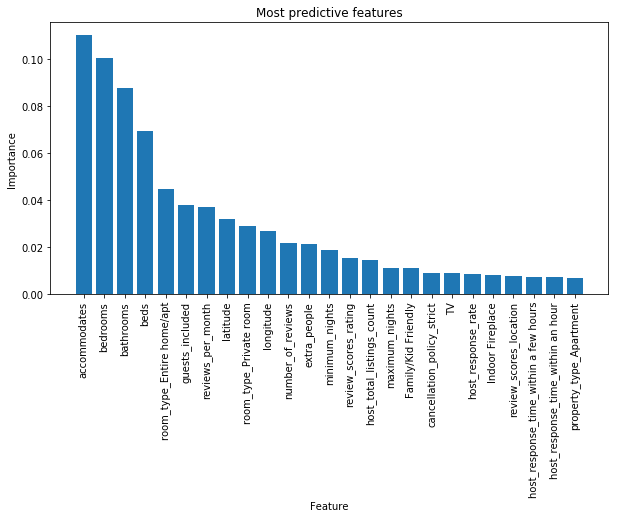

In [40]:
'''sorted_indices = np.argsort(best_model.feature_importances_)[::-1]
columns = X_train.columns[sorted_indices[:25]]
values = best_model.feature_importances_[sorted_indices][:25]
plt.figure(figsize=(10,5))
plt.bar(range(25), values)
plt.xticks(range(25), columns, rotation='vertical')'''

features = sorted(zip(best_model.feature_importances_, X_train.columns), reverse=True)
values = [x[0] for x in features]
columns = [x[1] for x in features]
plt.figure(figsize=(10,5))
plt.bar(columns[:25], values[:25])
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.xticks(rotation='vertical')
plt.title('Most predictive features')
plt.savefig('feature importance.png', bbox_inches = 'tight')
plt.show()

### Result Interpretation:
- We can see the most important features in determining prices are bedrooms, accomodates, bathrooms, beds and guests included. All these features actually indicate towards the size of the listing, and they are all related together. A listing with high number of bedrooms will obviously have higher number of bathrooms and beds, and will accomodate a larger number of guests. Such a listing will obviously have a higher price.

- Room type is also an important feature, which also makes perfect sense. Prices of entire home/apt will be higher than private rooms, which in turn will be higher than shared rooms.

- Reviews per month is also quite important. Higher reviews per month indicates higher occupancy rate per month, which usually drives the price higher.

- Latitude and longitude are also important features denoting the location of a listing. We already know from Question 2, neighbourhood is an important factor in determining prices.

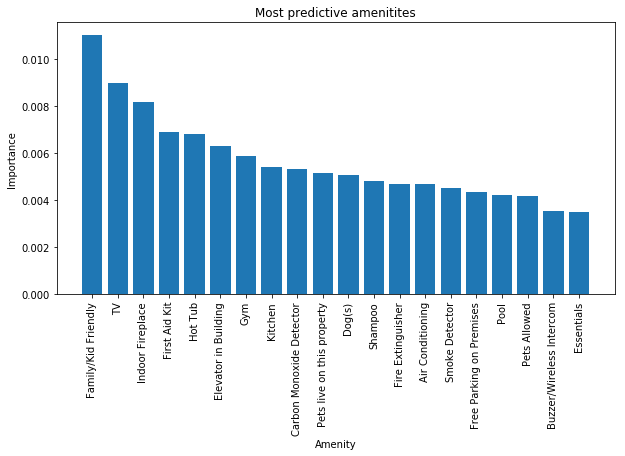

In [39]:
# Plot importances of amentities
'''importances = list(zip(best_model.feature_importances_, X_train))
importances_df = pd.DataFrame(importances, columns=['importances', 'columns']).sort_values(by=['importances'])

amenities_importance = importances_df[importances_df['columns'].isin(parsed_amenities.columns)]
plt.figure(figsize=(10,5))
plt.bar(amenities_importance['columns'], amenities_importance['importances'])
plt.xticks(rotation='vertical')'''

amenities_list = [x[1] for x in features if x[1] in set(parsed_amenities.columns)]
coef_list = [x[0] for x in features if x[1] in set(parsed_amenities.columns)]

plt.figure(figsize=(10,5))
plt.bar(amenities_list[:20], coef_list[:20])
plt.ylabel('Importance')
plt.xlabel('Amenity')
plt.xticks(rotation='vertical')
plt.title('Most predictive amenitites')
plt.savefig('amenity importance.png', bbox_inches = 'tight')
plt.show()

### Result interpretation:

We can see the most important amenities which influence price are Family/Kid Friendly, TV, Indoor Fireplace, Elevator in Building, Hot Tub, Gym and Kitchen.